# Import Price Data From Kraken API:

In [90]:
import krakenex 
from pykrakenapi import KrakenAPI
import sys
import time
import urllib.request
import json
import requests
import pandas as pd
import numpy as np 

import hvplot
import hvplot.pandas
from IPython.display import Markdown

from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.decomposition import PCA
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestRegressor

from ta.momentum import RSIIndicator

pd.set_option("display.max_rows", 2000)
pd.set_option("display.max_columns", 2000)
pd.set_option("display.width", 1000)

import warnings
warnings.filterwarnings('ignore')

In [91]:
api = krakenex.API()
k = KrakenAPI(api)

In [92]:
ohlc = k.get_ohlc_data("BTCUSD")

In [93]:
def fetch_OHLC_data(symbol, timeframe):
    pair_split = symbol.split('/')
    symbol = pair_split[0] + pair_split[1]
    url = f'https://api.kraken.com/0/public/OHLC?pair={symbol}&interval={timeframe}'
    response = requests.get(url)
    if response.status_code == 200: 
        j = json.loads(response.text)
        result = j['result']
        keys = []
        for item in result:
            keys.append(item)
        if keys[0] != 'last':
            data = pd.DataFrame(result[keys[0]],
                                columns=['unix', 'open', 'high', 'low', 'close', 'vwap', 'volume', 'tradecount'])
        else:
            data = pd.DataFrame(result[keys[1]],
                                columns=['unix', 'open', 'high', 'low', 'close', 'vwap', 'volume', 'tradecount'])

        data['date'] = pd.to_datetime(data['unix'], unit='s')
        data['volume_from'] = data['volume'].astype(float) * data['close'].astype(float)
    return data

In [94]:
btc = fetch_OHLC_data(symbol="BTC/USD", timeframe="1440")
btc = btc.drop(columns=["unix", "open", "high", "low", "volume_from"])
btc = btc.set_index("date")
btc['close'] = btc['close'].astype(float)
btc['returns'] = btc.close.pct_change()
btc['change_in_price'] = btc['returns']
btc.change_in_price[btc.change_in_price > 0] = 1
btc.change_in_price[btc.change_in_price <= 0] = 0
btc.dropna(inplace=True)
btc['change_in_price'] = btc['change_in_price'].astype(int)
btc.head()

,close,vwap,volume,tradecount,returns,change_in_price
date,,,,,,
2019-06-25,11765.1,11340.2,11623.88144358,40223,0.067555,1
2019-06-26,12933.7,12684.3,25637.82859518,100171,0.099328,1
2019-06-27,11148.0,11581.1,25035.66966057,90274,-0.138066,0
2019-06-28,12360.0,11681.2,13815.53621372,50195,0.108719,1
2019-06-29,11865.1,11839.0,10990.60288378,44270,-0.040040,0


# Generate Quantitative Trading Signals:

In [95]:
def generate_signals(btc):
    """Generates trading signals for a given dataset."""
    signals_df = btc.copy()
    # Set the short window and long windows
    short_window = 50
    long_window = 100

    # Generate the short and long moving averages signal (50 and 100 days, respectively)
    signals_df["SMA50"] = signals_df["close"].rolling(window=short_window).mean()
    signals_df["SMA100"] = signals_df["close"].rolling(window=long_window).mean()

    signals_df["long_sig"] = np.where(signals_df["SMA50"] > signals_df["SMA100"], 1.0, 0.0)
    signals_df["short_sig"] = np.where(signals_df["SMA50"] < signals_df["SMA100"], -1.0, 0.0)
    signals_df["SMA_signal"] = signals_df["long_sig"] + signals_df["short_sig"]
    
    # Calculate bollinger bands and upper and lowers bands of bollinger band and bollinger band signal
    signals_df['bollinger_mid_band'] = signals_df['close'].rolling(window=20).mean()
    signals_df['bollinger_std'] = signals_df['close'].rolling(window=20).std()

    signals_df['bollinger_upper_band']  = signals_df['bollinger_mid_band'] + (signals_df['bollinger_std'] * 1)
    signals_df['bollinger_lower_band']  = signals_df['bollinger_mid_band'] - (signals_df['bollinger_std'] * 1)

    signals_df['bollinger_long'] = np.where(signals_df['close'] < signals_df['bollinger_lower_band'], 1.0, 0.0)
    signals_df['bollinger_short'] = np.where(signals_df['close'] > signals_df['bollinger_upper_band'], -1.0, 0.0)
    signals_df['bollinger_signal'] = signals_df['bollinger_long'] + signals_df['bollinger_short']
    
    # Calculate RSI and RSI signals
    rsi_14 = RSIIndicator(close = signals_df.close, window = 14)
    signals_df["RSI"] = rsi_14.rsi()
    signals_df["RSI_long"] = np.where(signals_df["RSI"] < 30, 1.0, 0.0)
    signals_df["RSI_short"] = np.where(signals_df["RSI"] > 70, -1.0, 0.0)
    signals_df["RSI_signal"] = signals_df["RSI_long"] + signals_df["RSI_short"]
    
    # Calculate VWAP and VWAP signals
    signals_df['vwap'] = signals_df['vwap'].astype(float)
    signals_df['volume'] = signals_df['volume'].astype(float)
    signals_df["VWAP_long"] = np.where(signals_df["close"] < signals_df["vwap"], 1.0, 0.0)
    signals_df["VWAP_short"] = np.where(signals_df["close"] > signals_df["vwap"], -1.0, 0.0)
    signals_df["VWAP_signal"] = signals_df["VWAP_short"] + signals_df["VWAP_long"]
    signals_df["VWAP_signal"] = signals_df['VWAP_signal'].astype(float)
    
    return signals_df

In [96]:
all_sig = generate_signals(btc)
all_sig.tail()

,close,vwap,volume,tradecount,returns,change_in_price,SMA50,SMA100,long_sig,short_sig,SMA_signal,bollinger_mid_band,bollinger_std,bollinger_upper_band,bollinger_lower_band,bollinger_long,bollinger_short,bollinger_signal,RSI,RSI_long,RSI_short,RSI_signal,VWAP_long,VWAP_short,VWAP_signal
date,,,,,,,,,,,,,,,,,,,,,,,,,
2021-06-08,33420.0,32712.0,10548.326943,72896,-0.004990,0,46329.562,51419.813,0.0,-1.0,-1.0,36852.540,1967.902434,38820.442434,34884.637566,1.0,0.0,1.0,34.402798,0.0,0.0,0.0,0.0,-1.0,-1.0
2021-06-09,37396.4,34956.4,9357.472109,65863,0.118983,1,45947.490,51297.570,0.0,-1.0,-1.0,36691.630,1765.234552,38456.864552,34926.395448,0.0,0.0,0.0,45.112041,0.0,0.0,0.0,0.0,-1.0,-1.0
2021-06-10,36678.4,37034.3,7733.100593,56255,-0.019200,0,45604.754,51179.492,0.0,-1.0,-1.0,36658.965,1758.799723,38417.764723,34900.165277,0.0,0.0,0.0,43.723968,0.0,0.0,0.0,1.0,0.0,1.0
2021-06-11,37322.2,37016.7,5218.296832,37956,0.017553,1,45316.598,51048.714,0.0,-1.0,-1.0,36651.660,1755.561735,38407.221735,34896.098265,0.0,0.0,0.0,45.347791,0.0,0.0,0.0,0.0,-1.0,-1.0
2021-06-12,35425.6,36145.2,1944.691939,11814,-0.050817,0,45001.536,50919.670,0.0,-1.0,-1.0,36687.000,1721.386224,38408.386224,34965.613776,0.0,0.0,0.0,41.544672,0.0,0.0,0.0,1.0,0.0,1.0


In [97]:
all_sig.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 719 entries, 2019-06-25 to 2021-06-12
Data columns (total 25 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   close                 719 non-null    float64
 1   vwap                  719 non-null    float64
 2   volume                719 non-null    float64
 3   tradecount            719 non-null    int64  
 4   returns               719 non-null    float64
 5   change_in_price       719 non-null    int32  
 6   SMA50                 670 non-null    float64
 7   SMA100                620 non-null    float64
 8   long_sig              719 non-null    float64
 9   short_sig             719 non-null    float64
 10  SMA_signal            719 non-null    float64
 11  bollinger_mid_band    700 non-null    float64
 12  bollinger_std         700 non-null    float64
 13  bollinger_upper_band  700 non-null    float64
 14  bollinger_lower_band  700 non-null    float64
 15  boll

# Random Forest With Raw Variables

In [98]:
X = all_sig.copy()
X.dropna(inplace=True)
X.drop(columns=['close','returns','change_in_price'], inplace=True)
X.head()

,vwap,volume,tradecount,SMA50,SMA100,long_sig,short_sig,SMA_signal,bollinger_mid_band,bollinger_std,bollinger_upper_band,bollinger_lower_band,bollinger_long,bollinger_short,bollinger_signal,RSI,RSI_long,RSI_short,RSI_signal,VWAP_long,VWAP_short,VWAP_signal
date,,,,,,,,,,,,,,,,,,,,,,
2019-10-02,8262.6,3884.724758,12206,9863.328,10415.561,0.0,-1.0,-1.0,9315.040,977.974862,10293.014862,8337.065138,0.0,0.0,0.0,31.453494,0.0,0.0,0.0,0.0,-1.0,-1.0
2019-10-03,8206.0,5110.216416,14991,9827.730,10380.291,0.0,-1.0,-1.0,9208.840,973.603132,10182.443132,8235.236868,0.0,0.0,0.0,29.664955,1.0,0.0,1.0,0.0,-1.0,-1.0
2019-10-04,8148.2,3962.292889,10426,9784.684,10332.476,0.0,-1.0,-1.0,9098.290,961.075963,10059.365963,8137.214037,0.0,0.0,0.0,28.620895,1.0,0.0,1.0,0.0,-1.0,-1.0
2019-10-05,8113.9,2165.333389,7275,9740.410,10302.480,0.0,-1.0,-1.0,8990.145,938.830854,9928.975854,8051.314146,0.0,0.0,0.0,28.572987,1.0,0.0,1.0,0.0,-1.0,-1.0
2019-10-06,7956.0,4761.797350,14134,9693.434,10257.510,0.0,-1.0,-1.0,8870.265,920.973162,9791.238162,7949.291838,1.0,0.0,1.0,25.165807,1.0,0.0,1.0,1.0,0.0,1.0


In [99]:
y=all_sig['change_in_price'].values.reshape(-1,1)
y=y[99:]
y[:5]

array([[1],
       [0],
       [0],
       [0],
       [0]])

In [100]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=78)

In [101]:
scaler = StandardScaler()

In [102]:
X_scaler = scaler.fit(X_train)

In [103]:
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [104]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=78)

In [105]:
rf_model = rf_model.fit(X_train_scaled, y_train)

In [106]:
predictions = rf_model.predict(X_test_scaled)

In [107]:
cm = confusion_matrix(y_test, predictions)
cm_df = pd.DataFrame(
    cm, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"]
)

acc_score = accuracy_score(y_test, predictions)

In [108]:
print("Confusion Matrix")
display(cm_df)
print(f"Accuracy Score : {acc_score}")
print("Classification Report")
print(classification_report(y_test, predictions))

Confusion Matrix


,Predicted 0,Predicted 1
Actual 0,47,24
Actual 1,11,73


Accuracy Score : 0.7741935483870968
Classification Report
              precision    recall  f1-score   support

           0       0.81      0.66      0.73        71
           1       0.75      0.87      0.81        84

    accuracy                           0.77       155
   macro avg       0.78      0.77      0.77       155
weighted avg       0.78      0.77      0.77       155



In [109]:
importances = rf_model.feature_importances_

In [110]:
importances_sorted = sorted(zip(rf_model.feature_importances_, X.columns), reverse=True)

<AxesSubplot:title={'center':'Features Importances'}, ylabel='1'>

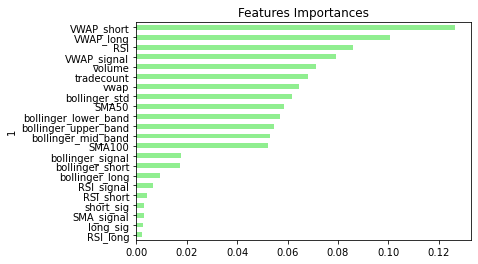

In [111]:
importances = pd.DataFrame(sorted(zip(rf_model.feature_importances_, X.columns), reverse=True))
importances.set_index(importances[1], inplace=True)
importances.drop(columns=1, inplace=True)
importances.rename(columns={0: 'Feature Importances'}, inplace=True)
importances_sorted = importances.sort_values(by='Feature Importances')
importances_sorted.plot(kind='barh', color='lightgreen', title= 'Features Importances', legend=False)

# Random Forest Predictions Selecting The Three Most Significant Signals

In [112]:
all_sig.tail()

,close,vwap,volume,tradecount,returns,change_in_price,SMA50,SMA100,long_sig,short_sig,SMA_signal,bollinger_mid_band,bollinger_std,bollinger_upper_band,bollinger_lower_band,bollinger_long,bollinger_short,bollinger_signal,RSI,RSI_long,RSI_short,RSI_signal,VWAP_long,VWAP_short,VWAP_signal
date,,,,,,,,,,,,,,,,,,,,,,,,,
2021-06-08,33420.0,32712.0,10548.326943,72896,-0.004990,0,46329.562,51419.813,0.0,-1.0,-1.0,36852.540,1967.902434,38820.442434,34884.637566,1.0,0.0,1.0,34.402798,0.0,0.0,0.0,0.0,-1.0,-1.0
2021-06-09,37396.4,34956.4,9357.472109,65863,0.118983,1,45947.490,51297.570,0.0,-1.0,-1.0,36691.630,1765.234552,38456.864552,34926.395448,0.0,0.0,0.0,45.112041,0.0,0.0,0.0,0.0,-1.0,-1.0
2021-06-10,36678.4,37034.3,7733.100593,56255,-0.019200,0,45604.754,51179.492,0.0,-1.0,-1.0,36658.965,1758.799723,38417.764723,34900.165277,0.0,0.0,0.0,43.723968,0.0,0.0,0.0,1.0,0.0,1.0
2021-06-11,37322.2,37016.7,5218.296832,37956,0.017553,1,45316.598,51048.714,0.0,-1.0,-1.0,36651.660,1755.561735,38407.221735,34896.098265,0.0,0.0,0.0,45.347791,0.0,0.0,0.0,0.0,-1.0,-1.0
2021-06-12,35425.6,36145.2,1944.691939,11814,-0.050817,0,45001.536,50919.670,0.0,-1.0,-1.0,36687.000,1721.386224,38408.386224,34965.613776,0.0,0.0,0.0,41.544672,0.0,0.0,0.0,1.0,0.0,1.0


In [113]:
x_var_list = ['RSI_signal', 'bollinger_signal', 'VWAP_signal']
all_sig[x_var_list].tail()

,RSI_signal,bollinger_signal,VWAP_signal
date,,,
2021-06-08,0.0,1.0,-1.0
2021-06-09,0.0,0.0,-1.0
2021-06-10,0.0,0.0,1.0
2021-06-11,0.0,0.0,-1.0
2021-06-12,0.0,0.0,1.0


In [114]:
all_sig.dropna(subset=x_var_list, inplace=True)
all_sig.dropna(subset=['returns'],inplace=True)
all_sig = all_sig.replace([np.inf, -np.inf], np.nan)
all_sig.head()

,close,vwap,volume,tradecount,returns,change_in_price,SMA50,SMA100,long_sig,short_sig,SMA_signal,bollinger_mid_band,bollinger_std,bollinger_upper_band,bollinger_lower_band,bollinger_long,bollinger_short,bollinger_signal,RSI,RSI_long,RSI_short,RSI_signal,VWAP_long,VWAP_short,VWAP_signal
date,,,,,,,,,,,,,,,,,,,,,,,,,
2019-06-25,11765.1,11340.2,11623.881444,40223,0.067555,1,NaN,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,-1.0,-1.0
2019-06-26,12933.7,12684.3,25637.828595,100171,0.099328,1,NaN,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,-1.0,-1.0
2019-06-27,11148.0,11581.1,25035.669661,90274,-0.138066,0,NaN,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,NaN,0.0,0.0,0.0,1.0,0.0,1.0
2019-06-28,12360.0,11681.2,13815.536214,50195,0.108719,1,NaN,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,-1.0,-1.0
2019-06-29,11865.1,11839.0,10990.602884,44270,-0.040040,0,NaN,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,-1.0,-1.0


In [115]:
all_sig['Positive Return'] = np.where(all_sig['returns'] > 0, 1.0, 0.0)
all_sig.tail()

,close,vwap,volume,tradecount,returns,change_in_price,SMA50,SMA100,long_sig,short_sig,SMA_signal,bollinger_mid_band,bollinger_std,bollinger_upper_band,bollinger_lower_band,bollinger_long,bollinger_short,bollinger_signal,RSI,RSI_long,RSI_short,RSI_signal,VWAP_long,VWAP_short,VWAP_signal,Positive Return
date,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-06-08,33420.0,32712.0,10548.326943,72896,-0.004990,0,46329.562,51419.813,0.0,-1.0,-1.0,36852.540,1967.902434,38820.442434,34884.637566,1.0,0.0,1.0,34.402798,0.0,0.0,0.0,0.0,-1.0,-1.0,0.0
2021-06-09,37396.4,34956.4,9357.472109,65863,0.118983,1,45947.490,51297.570,0.0,-1.0,-1.0,36691.630,1765.234552,38456.864552,34926.395448,0.0,0.0,0.0,45.112041,0.0,0.0,0.0,0.0,-1.0,-1.0,1.0
2021-06-10,36678.4,37034.3,7733.100593,56255,-0.019200,0,45604.754,51179.492,0.0,-1.0,-1.0,36658.965,1758.799723,38417.764723,34900.165277,0.0,0.0,0.0,43.723968,0.0,0.0,0.0,1.0,0.0,1.0,0.0
2021-06-11,37322.2,37016.7,5218.296832,37956,0.017553,1,45316.598,51048.714,0.0,-1.0,-1.0,36651.660,1755.561735,38407.221735,34896.098265,0.0,0.0,0.0,45.347791,0.0,0.0,0.0,0.0,-1.0,-1.0,1.0
2021-06-12,35425.6,36145.2,1944.691939,11814,-0.050817,0,45001.536,50919.670,0.0,-1.0,-1.0,36687.000,1721.386224,38408.386224,34965.613776,0.0,0.0,0.0,41.544672,0.0,0.0,0.0,1.0,0.0,1.0,0.0


In [116]:
x_var = ['RSI_signal', 'bollinger_signal', 'VWAP_signal', 'Positive Return']
rf_df = all_sig[x_var]
rf_df.dropna(inplace=True)
X_test = rf_df[x_var_list]
y_test = rf_df["Positive Return"]

In [117]:
X_test.tail()

,RSI_signal,bollinger_signal,VWAP_signal
date,,,
2021-06-08,0.0,1.0,-1.0
2021-06-09,0.0,0.0,-1.0
2021-06-10,0.0,0.0,1.0
2021-06-11,0.0,0.0,-1.0
2021-06-12,0.0,0.0,1.0


In [118]:
y_test.tail()

date
2021-06-08    0.0
2021-06-09    1.0
2021-06-10    0.0
2021-06-11    1.0
2021-06-12    0.0
Name: Positive Return, dtype: float64

In [119]:
rf_reg = RandomForestRegressor(n_estimators = 100, random_state = 78)
rf_reg.fit(X_test, y_test);
pred = rf_reg.predict(X_test)

In [120]:
rf_df["Predict"] = pred
rf_df.tail()

,RSI_signal,bollinger_signal,VWAP_signal,Positive Return,Predict
date,,,,,
2021-06-08,0.0,1.0,-1.0,0.0,0.545405
2021-06-09,0.0,0.0,-1.0,1.0,0.734548
2021-06-10,0.0,0.0,1.0,0.0,0.154246
2021-06-11,0.0,0.0,-1.0,1.0,0.734548
2021-06-12,0.0,0.0,1.0,0.0,0.154246


In [121]:
thresh = np.arange(0,1,0.1)
real_thresh = thresh[3]
rf_df['Binary Predict'] = np.where(rf_df["Predict"] > real_thresh, 1, 0)
rf_df.tail()

,RSI_signal,bollinger_signal,VWAP_signal,Positive Return,Predict,Binary Predict
date,,,,,,
2021-06-08,0.0,1.0,-1.0,0.0,0.545405,1
2021-06-09,0.0,0.0,-1.0,1.0,0.734548,1
2021-06-10,0.0,0.0,1.0,0.0,0.154246,0
2021-06-11,0.0,0.0,-1.0,1.0,0.734548,1
2021-06-12,0.0,0.0,1.0,0.0,0.154246,0


In [122]:
predicted = rf_df["Binary Predict"]

In [123]:
def assign_threshold(x):
    
    if x < 0.2:
        
        return 'sell'
    
    elif x >= 0.2 and x < 0.5:
        
        return 'hold'
    
    else:
                
        return 'buy'

In [124]:
rf_df['Recommend'] = rf_df['Predict'].apply(assign_threshold)
rf_df.tail(20)

,RSI_signal,bollinger_signal,VWAP_signal,Positive Return,Predict,Binary Predict,Recommend
date,,,,,,,
2021-05-24,0.0,1.0,-1.0,1.0,0.545405,1,buy
2021-05-25,0.0,1.0,-1.0,0.0,0.545405,1,buy
2021-05-26,0.0,0.0,-1.0,1.0,0.734548,1,buy
2021-05-27,0.0,0.0,1.0,0.0,0.154246,0,sell
2021-05-28,0.0,1.0,1.0,0.0,0.103505,0,sell
2021-05-29,0.0,1.0,1.0,0.0,0.103505,0,sell
2021-05-30,0.0,0.0,-1.0,1.0,0.734548,1,buy
2021-05-31,0.0,0.0,-1.0,1.0,0.734548,1,buy
2021-06-01,0.0,0.0,1.0,0.0,0.154246,0,sell


In [125]:
Results = rf_df.drop(columns=['RSI_signal','bollinger_signal','VWAP_signal'])


# Results = y.to_frame()
# Results["Binary Prediction"] = predicted
# Results["returns"] = all_sig['returns']
# Results['close'] = all_sig["close"]
# Results["Recommend"] = rf_df["Recommend"]
Results.tail()

,Positive Return,Predict,Binary Predict,Recommend
date,,,,
2021-06-08,0.0,0.545405,1,buy
2021-06-09,1.0,0.734548,1,buy
2021-06-10,0.0,0.154246,0,sell
2021-06-11,1.0,0.734548,1,buy
2021-06-12,0.0,0.154246,0,sell


<AxesSubplot:xlabel='date'>

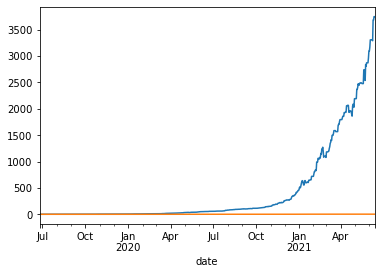

In [126]:
# Calculate cumulative return of model and plot the result
(1 + (all_sig['returns'] * Results['Binary Predict'])).cumprod().plot()
(1 + all_sig['returns']).cumprod().plot()

<AxesSubplot:xlabel='date'>

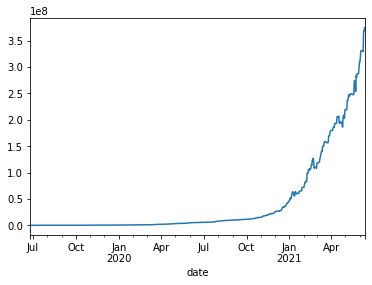

In [127]:
# Set initial capital allocation
initial_capital = 100000

# Plot cumulative return of model in terms of capital
cumulative_return_capital = initial_capital * (1 + (all_sig['returns'] * Results['Binary Predict'])).cumprod()
cumulative_return_capital.plot()

In [128]:
final_results = Results.drop(columns=['Positive Return','Predict','Binary Predict'])
final_results['close'] = all_sig['close']
final_results.head(50)

,Recommend,close
date,,
2019-06-25,buy,11765.1
2019-06-26,buy,12933.7
2019-06-27,sell,11148.0
2019-06-28,buy,12360.0
2019-06-29,buy,11865.1
2019-06-30,sell,10752.3
2019-07-01,buy,10575.9
2019-07-02,buy,10837.3
2019-07-03,buy,11979.8


In [130]:
trial_results = final_results.copy()

# Backtest the Trading Strategy:

In [177]:
wallet = 100000
equity = 0
num_coins = 0
wallet_history = []
equity_history = []
num_coins_history = []

for i in range(len(final_results)):


    if equity > 0 and final_results['Recommend'].iloc[i] == 'sell':

        wallet = num_coins * final_results['close'].iloc[i]
        equity = 0
        num_coins = 0
        
        wallet_history.append(wallet)
        equity_history.append(equity)
        num_coins_history.append(num_coins)

    elif wallet > 0 and final_results['Recommend'].iloc[i] == 'buy':
        num_coins = wallet / final_results['close'].iloc[i]
        equity = num_coins * final_results['close'].iloc[i]
        wallet = 0
        
        wallet_history.append(wallet)
        equity_history.append(equity)
        num_coins_history.append(num_coins)
            
    else:
        equity = num_coins * final_results['close'].iloc[i]
        wallet_history.append(wallet)
        equity_history.append(equity)
        num_coins_history.append(num_coins)
        


In [178]:
final_results['wallet'] = wallet_history
final_results['share equity'] = equity_history
final_results['total equity'] = final_results['share equity'] + final_results['wallet']
final_results['num coins'] = num_coins_history

final_results.tail()

,Recommend,close,wallet,share equity,total equity,num coins
date,,,,,,
2021-06-08,buy,33420.0,0.000000,127770.922955,127770.922955,3.823187
2021-06-09,buy,37396.4,0.000000,142973.445338,142973.445338,3.823187
2021-06-10,sell,36678.4,140228.396784,0.000000,140228.396784,0.000000
2021-06-11,buy,37322.2,0.000000,140228.396784,140228.396784,3.757238
2021-06-12,sell,35425.6,133102.418751,0.000000,133102.418751,0.000000


<AxesSubplot:xlabel='date'>

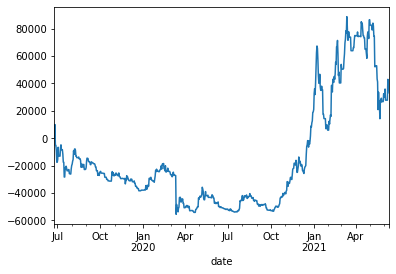

In [179]:
(final_results['total equity'] - 100000).plot()

# New Strategy

In [173]:
wallet = 100000
equity = 0
num_coins = 0
wallet_history = []
equity_history = []
num_coins_history = []
trade_per = 0.2

for i in range(len(trial_results)):
    
    if equity > 0 and trial_results['Recommend'].iloc[i] == 'sell':
        coin_change = (equity * trade_per) / trial_results['close'].iloc[i]
        wallet = wallet + (coin_change * trial_results['close'].iloc[i])
        num_coins = num_coins - coin_change
        equity = num_coins * trial_results['close'].iloc[i]
        
        wallet_history.append(wallet)
        equity_history.append(equity)
        num_coins_history.append(num_coins)

    elif wallet > 0 and trial_results['Recommend'].iloc[i] == 'buy':
        coin_change = (wallet * trade_per) / trial_results['close'].iloc[i] 
        wallet = wallet - (wallet * trade_per)
        num_coins = num_coins + coin_change
        equity = num_coins * trial_results['close'].iloc[i]

        wallet_history.append(wallet)
        equity_history.append(equity)
        num_coins_history.append(num_coins)
                    
    else:
        equity = num_coins * trial_results['close'].iloc[i]
        wallet_history.append(wallet)
        equity_history.append(equity)
        num_coins_history.append(num_coins)
        

In [176]:
trial_results['wallet'] = wallet_history
trial_results['share equity'] = equity_history
trial_results['total equity'] = trial_results['share equity'] + trial_results['wallet']
trial_results['num coins'] = num_coins_history

trial_results.tail()

,Recommend,close,wallet,share equity,total equity,num coins
date,,,,,,
2021-06-08,buy,33420.0,153437.552029,102165.404929,255602.956957,3.057014
2021-06-09,buy,37396.4,122750.041623,145008.825453,267758.867076,3.877615
2021-06-10,sell,36678.4,151751.806713,113222.933102,264974.739816,3.086910
2021-06-11,buy,37322.2,121401.445371,145560.647337,266962.092708,3.900109
2021-06-12,sell,35425.6,150513.574838,109051.571180,259565.146019,3.078327


<AxesSubplot:xlabel='date'>

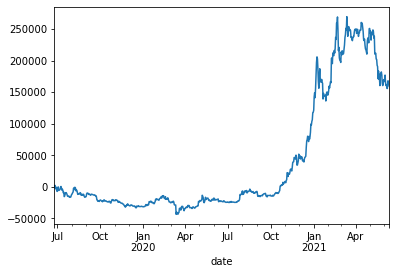

In [175]:
(trial_results['total equity'] - 100000).plot()

In [142]:
# print(wallet_history)
# print(equity_history)
# print(num_coins_history)

In [55]:
wallet = 100000
share_size = 1

rf_df["close"] = all_sig["close"]
# Take a 500 share position where the dual moving average crossover is 1 (SMA50 is greater than SMA100)
rf_df['Position'] = share_size * rf_df['close']

# Find the points in time where a 500 share position is bought or sold
rf_df['Entry/Exit Position'] = rf_df['Position'].diff()

# Multiply share price by entry/exit positions and get the cumulatively sum
rf_df['Portfolio Holdings'] = rf_df['close'] * rf_df['Entry/Exit Position'].cumsum()

# Subtract the initial capital by the portfolio holdings to get the amount of liquid cash in the portfolio
rf_df['Portfolio Cash'] = wallet - (rf_df['close'] * rf_df['Entry/Exit Position']).cumsum()

# Get the total portfolio value by adding the cash amount by the portfolio holdings (or investments)
rf_df['Portfolio Total'] = rf_df['Portfolio Cash'] + rf_df['Portfolio Holdings']

# Calculate the portfolio daily returns
rf_df['Portfolio Daily Returns'] = rf_df['Portfolio Total'].pct_change()

# Calculate the cumulative returns
rf_df['Portfolio Cumulative Returns'] = (1 + rf_df['Portfolio Daily Returns']).cumprod() - 1

# Print the DataFrame
rf_df.tail()

,RSI_signal,bollinger_signal,VWAP_signal,Positive Return,Predict,Binary Predict,Recommend,close,Position,Entry/Exit Position,Portfolio Holdings,Portfolio Cash,Portfolio Total,Portfolio Daily Returns,Portfolio Cumulative Returns
date,,,,,,,,,,,,,,,
2021-06-07,0.0,1.0,1.0,0.0,0.097554,0,sell,33587.6,33587.6,-2201.4,7.579714e+08,-9.234900e+08,-1.655186e+08,0.491246,-1656.186441
2021-06-08,0.0,1.0,-1.0,0.0,0.532842,1,buy,33420.0,33420.0,-167.6,7.485879e+08,-9.178888e+08,-1.693009e+08,0.022851,-1694.008733
2021-06-09,0.0,0.0,-1.0,1.0,0.731257,1,buy,37396.4,37396.4,3976.4,9.863600e+08,-1.066592e+09,-8.023190e+07,-0.526099,-803.318991
2021-06-10,0.0,0.0,1.0,0.0,0.161330,0,sell,36678.4,36678.4,-718.0,9.410871e+08,-1.040257e+09,-9.916972e+07,0.236039,-992.697235
2021-06-11,0.0,0.0,-1.0,1.0,0.731257,1,buy,37021.2,37021.2,342.8,9.625734e+08,-1.052948e+09,-9.037423e+07,-0.088691,-904.742297


In [56]:
# Visualize exit position relative to close price
exit = rf_df[rf_df['VWAP_signal'] == -1.0]['close'].hvplot.scatter(
    color='red',
    legend=False,
    ylabel='Price in $',
    width=1000,
    height=400
)

# Visualize entry position relative to close price
entry = rf_df[rf_df['VWAP_signal'] == 1.0]['close'].hvplot.scatter(
    color='green',
    legend=False,
    ylabel='Price in $',
    width=1000,
    height=400
)

# Visualize close price for the investment
coin_close = rf_df[['close']].hvplot(
    line_color='lightgray',
    ylabel='Price in $',
    width=1000,
    height=400
)

vwap = all_sig[['vwap']].hvplot(ylabel='Price in $',
    width=1000,
    height=400
)

# Overlay plots
entry_exit_plot = coin_close * vwap * entry * exit
entry_exit_plot.opts(xaxis=None)

:Overlay
   .Curve.I          :Curve   [date]   (close)
   .Curve.II         :Curve   [date]   (vwap)
   .Scatter.Close.I  :Scatter   [date]   (close)
   .Scatter.Close.II :Scatter   [date]   (close)

In [57]:
# Visualize exit position relative to close price
exit = all_sig[all_sig['bollinger_signal'] == -1.0]['close'].hvplot.scatter(
    color='red',
    legend=False,
    ylabel='Price in $',
    width=1000,
    height=400
)

# Visualize entry position relative to close price
entry = all_sig[all_sig['bollinger_signal'] == 1.0]['close'].hvplot.scatter(
    color='green',
    legend=False,
    ylabel='Price in $',
    width=1000,
    height=400
)

# Visualize close price for the investment
coin_close = rf_df[['close']].hvplot(
    line_color='lightgray',
    ylabel='Price in $',
    width=1000,
    height=400
)

bol_bands = all_sig[['bollinger_mid_band', 'bollinger_upper_band', 'bollinger_lower_band']].hvplot(
    ylabel='Price in $',
    width=1000,
    height=400
)

# Overlay plots
entry_exit_plot = coin_close * bol_bands * entry * exit
entry_exit_plot.opts(xaxis=None)


:Overlay
   .Curve.I          :Curve   [date]   (close)
   .NdOverlay.I      :NdOverlay   [Variable]
      :Curve   [date]   (value)
   .Scatter.Close.I  :Scatter   [date]   (close)
   .Scatter.Close.II :Scatter   [date]   (close)

In [58]:
# Visualize exit position relative to close price
exit = all_sig[all_sig['RSI_signal'] == -1.0]['close'].hvplot.scatter(
    color='red',
    legend=False,
    ylabel='Price in $',
    width=1000,
    height=400
)

# Visualize entry position relative to close price
entry = all_sig[all_sig['RSI_signal'] == 1.0]['close'].hvplot.scatter(
    color='green',
    legend=False,
    ylabel='Price in $',
    width=1000,
    height=400
)

# Visualize close price for the investment
coin_close = rf_df[['close']].hvplot(
    line_color='lightgray',
    ylabel='Price in $',
    width=1000,
    height=400
)

RSI = all_sig[['RSI']].hvplot(
    ylabel='Price in $',
    width=1000,
    height=400
)

# Overlay plots
entry_exit_plot = coin_close * RSI * entry * exit
entry_exit_plot.opts(xaxis=None)

:Overlay
   .Curve.I          :Curve   [date]   (close)
   .Curve.II         :Curve   [date]   (RSI)
   .Scatter.Close.I  :Scatter   [date]   (close)
   .Scatter.Close.II :Scatter   [date]   (close)

In [73]:
# Visualize exit position relative to close price
exit = rf_df[rf_df['binary_predict'] == -1.0]['close'].hvplot.scatter(
    color='red',
    legend=False,
    ylabel='Price in $',
    width=1000,
    height=400
)
​
# Visualize entry position relative to close price
entry = all_sig[all_sig['RSI_signal'] == 1.0]['close'].hvplot.scatter(
    color='green',
    legend=False,
    ylabel='Price in $',
    width=1000,
    height=400
)
​
# Visualize close price for the investment
coin_close = rf_df[['close']].hvplot(
    line_color='lightgray',
    ylabel='Price in $',
    width=1000,
    height=400
)
​
RSI = all_sig[['RSI']].hvplot(
    ylabel='Price in $',
    width=1000,
    height=400
)
​
# Overlay plots
entry_exit_plot = coin_close * RSI * entry * exit
entry_exit_plot.opts(xaxis=None)


SyntaxError: invalid character in identifier (<ipython-input-73-e6b61ede3e11>, line 9)

In [59]:
# Prepare DataFrame for metrics
metrics = [
    'Annual Return',
    'Cumulative Returns',
    'Annual Volatility',
    'Sharpe Ratio',
    'Sortino Ratio']

columns = ['Backtest']

# Initialize the DataFrame with index set to evaluation metrics and column as `Backtest` (just like PyFolio)
portfolio_evaluation_df = pd.DataFrame(index=metrics, columns=columns)
portfolio_evaluation_df

,Backtest
Annual Return,NaN
Cumulative Returns,NaN
Annual Volatility,NaN
Sharpe Ratio,NaN
Sortino Ratio,NaN


In [61]:
# Calculate cumulative return
portfolio_evaluation_df.loc['Cumulative Returns'] = rf_df['Portfolio Cumulative Returns'][-1]

# Calculate annualized return
portfolio_evaluation_df.loc['Annual Return'] = (
    rf_df['Portfolio Daily Returns'].mean() * 252
)

# Calculate annual volatility
portfolio_evaluation_df.loc['Annual Volatility'] = (
    rf_df['Portfolio Daily Returns'].std() * np.sqrt(252)
)

# Calculate Sharpe Ratio
portfolio_evaluation_df.loc['Sharpe Ratio'] = (
    rf_df['Portfolio Daily Returns'].mean() * 252) / (
    rf_df['Portfolio Daily Returns'].std() * np.sqrt(252)
)

# Calculate Downside Return
sortino_ratio_df = rf_df[['Portfolio Daily Returns']].copy()
sortino_ratio_df.loc[:,'Downside Returns'] = 0

target = 0
mask = sortino_ratio_df['Portfolio Daily Returns'] < target
sortino_ratio_df.loc[mask, 'Downside Returns'] = sortino_ratio_df['Portfolio Daily Returns']**2
portfolio_evaluation_df

# Calculate Sortino Ratio
down_stdev = np.sqrt(sortino_ratio_df['Downside Returns'].mean()) * np.sqrt(252)
expected_return = sortino_ratio_df['Portfolio Daily Returns'].mean() * 252
sortino_ratio = expected_return/down_stdev

portfolio_evaluation_df.loc['Sortino Ratio'] = sortino_ratio
portfolio_evaluation_df.head()

,Backtest
Annual Return,179.851159
Cumulative Returns,-904.742297
Annual Volatility,291.370006
Sharpe Ratio,0.61726
Sortino Ratio,44.898473


In [62]:
# Initialize trade evaluation DataFrame with columns
trade_evaluation_df = pd.DataFrame(
    columns=[
        'Crypto', 
        'Entry Date', 
        'Exit Date', 
        'Shares', 
        'Entry Share Price', 
        'Exit Share Price', 
        'Entry Portfolio Holding', 
        'Exit Portfolio Holding', 
        'Profit/Loss']
)

trade_evaluation_df

,Crypto,Entry Date,Exit Date,Shares,Entry Share Price,Exit Share Price,Entry Portfolio Holding,Exit Portfolio Holding,Profit/Loss


In [72]:
# Initialize iterative variables
entry_date = ''
exit_date = ''
entry_portfolio_holding = 0
exit_portfolio_holding = 0
share_size = 0
entry_share_price = 0
exit_share_price = 0

# Loop through signal DataFrame
# If `Entry/Exit` is 1, set entry trade metrics
# Else if `Entry/Exit` is -1, set exit trade metrics and calculate profit,
# Then append the record to the trade evaluation DataFrame
for index, row in rf_df.iterrows():
    if row['Binary_Predict'] == 1:
        entry_date = index
        entry_portfolio_holding = abs(row['Portfolio Holdings'])
        share_size = row['Entry/Exit Position']
        entry_share_price = row['close']

    elif row['Entry/Exit'] == -1:
        exit_date = index
        exit_portfolio_holding = abs(row['close'] * row['Entry/Exit Position'])
        exit_share_price = row['close']
        profit_loss =  entry_portfolio_holding - exit_portfolio_holding
        trade_evaluation_df = trade_evaluation_df.append(
            {
                'Crypto': 'BTC',
                'Entry Date': entry_date,
                'Exit Date': exit_date,
                'Shares': share_size,
                'Entry Share Price': entry_share_price,
                'Exit Share Price': exit_share_price,
                'Entry Portfolio Holding': entry_portfolio_holding,
                'Exit Portfolio Holding': exit_portfolio_holding,
                'Profit/Loss': profit_loss
            },
            ignore_index=True)

# Print the DataFrame
trade_evaluation_df

KeyError: 'Binary_Predict'

In [ ]:
price_df = rf_df[['close', 'SMA50', 'SMA100']]
price_chart = price_df.hvplot.line()
price_chart.opts(xaxis=None)

In [ ]:
portfolio_evaluation_df.reset_index(inplace=True)
portfolio_evaluation_table = portfolio_evaluation_df.hvplot.table()
portfolio_evaluation_table

In [ ]:
trade_evaluation_table = trade_evaluation_df.hvplot.table()
trade_evaluation_table

In [ ]:
# Assemble dashboard visualization
display(Markdown("# Trading Dashboard"))
display(price_chart)
portfolio_evaluation_table + trade_evaluation_table